- Peut-on établir un lien entre la densité de médecins par spécialité et par territoire et la pratique du dépassement d'honoraires ? 
- Est-ce dans les territoires où la densité est la plus forte que les médecins pratiquent le moins les dépassements d'honoraires ? 
- Est-ce que la densité de certains médecins / praticiens est corrélée à la densité de population pour certaines classes d'âges (bébé/pédiatre, personnes âgées / infirmiers etc...) ?

C'est un sujet issu du Hackathon "données de santé" de Etalab (la page contient des liens vers différents jeux de données utiles, ainsi que d'autres exemples de questions que vous pouvez préférer aborder). Vous pouvez compléter ça avec des données de l'INSEE et des données sur la démographie des médecins.

In [128]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# cartopy package : via "conda install -c conda-forge cartopy"

## 1. Chargement des données

Nous avons choisi d'utiliser les données fournies sur le site Ameli pour l'année de référence 2017
Ces données sont par département 


In [134]:
# chargement des données relatives à la démographie des médecins et à leurs honoraires
# nous ne conservons que les feuilles relatives aux spécialistes

df_specialistes = pd.read_excel('data/Effectif_et_densite_par_departement_en_2017.xls',
                                sheet_name="Spécialistes")
df_honoraires = pd.read_excel('data/Honoraires_totaux_des_professionnels_de_sante_par_departement_en_2017.xls',
                              sheet_name="Spécialistes",
                              na_values = 'nc')

In [135]:
# nous ne considérons dans un premier temps que le total des spécialistes, sans distinguer les différentes spécialités
df_totaux_spe = df_specialistes[df_specialistes["Spécialistes"]=="TOTAL SPECIALISTES"]
df_specialistes.head()

df = pd.merge(df_totaux_spe, df_honoraires, how='inner')

df.tail(10)


,Spécialistes,DEPARTEMENT,EFFECTIF,POPULATION FRANCAISE,DENSITE /100 000 hab.,EFFECTIFS,HONORAIRES SANS DEPASSEMENT (Euros),DEPASSEMENTS (Euros),FRAIS DE DEPLACEMENT (Euros),TOTAL DES HONORAIRES (Euros)
94,TOTAL SPECIALISTES,94- Val-de-Marne,1046,1.401200e+06,74.650304,1046,2.058237e+08,6.977177e+07,35292.21,2.756308e+08
95,TOTAL SPECIALISTES,95- Val-d'Oise,782,1.242700e+06,62.927500,782,2.082409e+08,5.976310e+07,1712.42,2.680057e+08
96,TOTAL SPECIALISTES,TOTAL FRANCE METROPOLITAINE,53577,6.501800e+07,82.403340,53577,1.253473e+10,2.728303e+09,344421.18,1.526338e+10
97,TOTAL SPECIALISTES,971- Guadeloupe,256,3.907076e+05,65.522150,256,6.773426e+07,4.314163e+06,86.25,7.204851e+07
98,TOTAL SPECIALISTES,972- Martinique,219,3.712072e+05,58.996702,219,4.862361e+07,7.415848e+06,20.00,5.603948e+07
99,TOTAL SPECIALISTES,973- Guyane,56,2.816055e+05,19.885978,56,1.290419e+07,7.599736e+05,0.00,1.366416e+07
100,TOTAL SPECIALISTES,974- Réunion,501,8.658168e+05,57.864437,501,1.649367e+08,7.864776e+06,26.57,1.728015e+08
101,TOTAL SPECIALISTES,976- Mayotte,4,2.592050e+05,1.543180,4,NaN,NaN,NaN,NaN
102,TOTAL SPECIALISTES,TOTAL OUTRE-MER,1036,2.168542e+06,47.774034,1036,2.951536e+08,2.040039e+07,132.82,3.155542e+08
103,TOTAL SPECIALISTES,TOTAL France ENTIERE,54613,6.718654e+07,81.285629,54613,1.282989e+10,2.748704e+09,344554.00,1.557893e+10


In [136]:
# les colonnes EFFECTIF et EFFECTIFS étant en doublon, nous en enlevons une
# nous nettoyons également les lignes cumulatives ou non remplies
df = df.drop(columns=["EFFECTIFS"])
df = df.drop([96,101,102,103])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 100
Data columns (total 9 columns):
Spécialistes                           100 non-null object
DEPARTEMENT                            100 non-null object
EFFECTIF                               100 non-null int64
POPULATION FRANCAISE                   100 non-null float64
DENSITE /100 000 hab.                  100 non-null float64
HONORAIRES SANS DEPASSEMENT (Euros)    100 non-null float64
DEPASSEMENTS (Euros)                   100 non-null float64
FRAIS DE DEPLACEMENT (Euros)           100 non-null float64
TOTAL DES HONORAIRES (Euros)           100 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 7.8+ KB


In [137]:
df.describe()

,EFFECTIF,POPULATION FRANCAISE,DENSITE /100 000 hab.,HONORAIRES SANS DEPASSEMENT (Euros),DEPASSEMENTS (Euros),FRAIS DE DEPLACEMENT (Euros),TOTAL DES HONORAIRES (Euros)
count,100.000000,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,100.000000,1.000000e+02
mean,546.090000,6.692733e+05,68.435444,1.282893e+08,2.748658e+07,3445.540000,1.557793e+08
std,702.259515,5.125698e+05,29.604314,1.295567e+08,6.316097e+07,6227.880497,1.813504e+08
min,28.000000,7.550000e+04,19.885978,6.818821e+06,1.234159e+05,0.000000,6.942300e+06
25%,161.750000,2.992250e+05,51.713070,4.208546e+07,4.161796e+06,88.350000,4.900213e+07
50%,303.000000,5.355500e+05,64.278865,7.608284e+07,8.853340e+06,869.135000,8.582661e+07
75%,632.000000,8.388042e+05,77.639011,1.672364e+08,2.460727e+07,3424.007500,1.864572e+08
max,5269.000000,2.613900e+06,242.979033,6.708895e+08,5.615594e+08,35292.210000,1.232463e+09


## 2. Dépassement d'honoraires et densité de spécialistes

Nous calculons le taux de dépassement d'honoraires et regardons la corrélation avec la densité de spécialistes

In [138]:
# la référence est volontairement les honoraires sans dépassement plutôt que les honoraires totaux pour éviter de 
# considérer les frais de déplacement
df["taux_depassement"] = df["DEPASSEMENTS (Euros)"] / df["HONORAIRES SANS DEPASSEMENT (Euros)"]

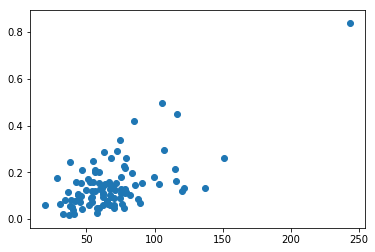

In [180]:
plt.figure()
plt.scatter(df["DENSITE /100 000 hab."],df["taux_depassement"])
plt.show()

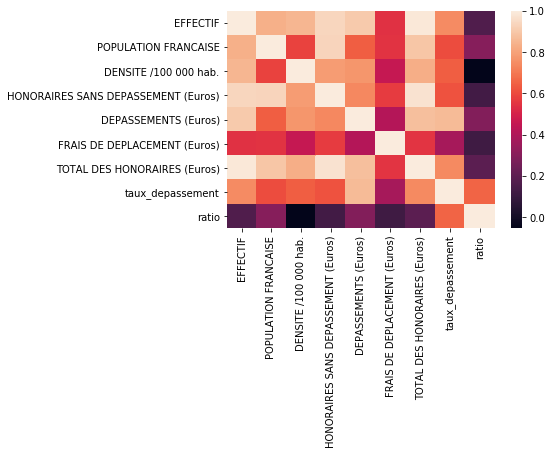

In [186]:
correlations = df.corr()
corr_heat = sns.heatmap(correlations)

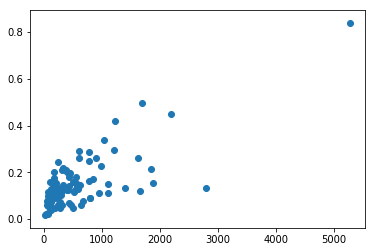

In [141]:
plt.figure()
plt.scatter(df["EFFECTIF"],df["taux_depassement"])
plt.show()

## Observation :

le taux de dépassement d'honoraires croit avec la densité de spécialistes, au moins jusqu'à 2000.
Au delà, on constate le cas particulier de Paris, et il est difficile de déduire des deux points intermédiaires si cette augmentation peut se poursuivre ou non.

Il semble y avoir deux distributions, au dessus et en dessous de la ligne moyenne.
Nous tenterons de voir sur une carte quels sont les départements dans chacun des cas, pour essayer différentes features pouvant expliquer cette distinction.

In [178]:
df["dept_code"] = df["DEPARTEMENT"].str.split('- ').str[0]
print(df.dept_code.unique())
df = df.set_index("dept_code")


['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '2A' '2B' '21' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41'
 '42' '43' '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55'
 '56' '57' '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69'
 '70' '71' '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83'
 '84' '85' '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '971' '972'
 '973' '974']


In [184]:
df['ratio'] = df["taux_depassement"]/df["DENSITE /100 000 hab."]*10000
df['ratio'].describe()

count    100.000000
mean      21.460166
std       12.315120
min        4.240808
25%       12.914940
50%       18.334736
75%       27.448785
max       65.027037
Name: ratio, dtype: float64

4
66


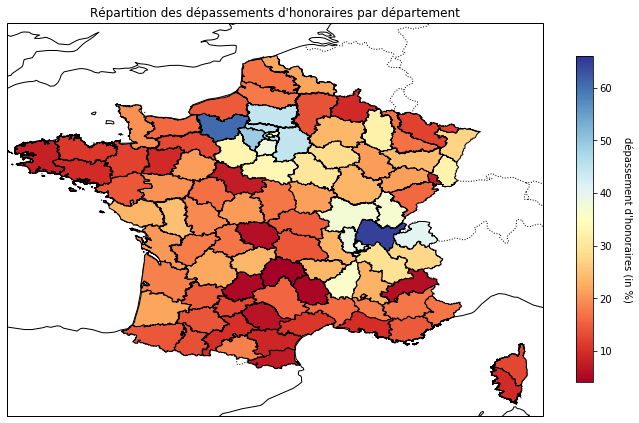

In [185]:
## influence du territoire ?
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from mpl_toolkits.axes_grid1 import make_axes_locatable

# nous prenons la référence de 2017 car c'est la même année que les données d'Ameli
reader = shpreader.Reader("data/departements-20170102.shp")
departements = reader.records()

# min et max
#dep_min = int(df["DENSITE /100 000 hab."].min())
#dep_max = int(df["DENSITE /100 000 hab."].max()) + 1
dep_min = int(df["ratio"].min())
dep_max = int(df["ratio"].max()) + 1


print(dep_min)
print(dep_max)

cmap = plt.cm.RdYlBu
norm = plt.Normalize(dep_min, dep_max)

# create figure
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title("Répartition des dépassements d'honoraires par département")

ax.set_extent([-5.0, 10.0, 41.0, 52.0])
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
ax.coastlines('50m')

for dept in departements:
    idx = dept.attributes['code_insee']
    if idx in ['69D', '69M']:
        idx = '69'
    if idx in df.index:
        #color = cmap(norm(df.loc[idx,"DENSITE /100 000 hab."]))
        color = cmap(norm(df.loc[idx,"ratio"]))
        # `dept.geometry` is the polygon to plot
        ax.add_geometries([dept.geometry], ccrs.PlateCarree(),
                          facecolor=color, edgecolor='black')

# Make a 'colorbar'
# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax, shrink=.5)
cbar.set_label("ratio entre dépassement d'honoraires et densité de spécialistes", labelpad=20, rotation=270)

plt.show()

La répartition géographique ne nous aide pas beaucoup : des grandes métropoles se trouvent dans les zones bleues, mais pas selement (cf la Normandie) et les zones d'autres grandes villes comme Marseille ou Toulouse ne sont pas dedans.

In [187]:
## par spécialité
df_specialistes["Spécialistes"].unique()


array(['02- Anesthésie-réanimation chirurgicale',
       '20- Réanimation médicale',
       'TOTAL ANESTHESIE REANIMATION  (02, 20)',
       '03- Pathologie cardio-vasculaire', '43- Chirurgie infantile',
       '44- Chirurgie maxillo-faciale',
       '46- Chirurgie plastique reconstructrice et esthétique',
       '47- Chirurgie thoracique et cardio-vasculaire',
       '48- Chirurgie vasculaire', '49- Chirurgie viscérale et digestive',
       '04- Chirurgie générale', '10- Neurochirurgie',
       '16- Chirurgie urologique',
       '41- Chirurgie orthopédique et traumatologie',
       'TOTAL CHIRURGIE  (43, 44, 46, 47, 48, 49, 04, 10, 16 ,41)',
       '05- Dermato-vénéréologie', '72- Médecine nucléaire',
       '74- Oncologie radiothérapique', '76- Radiothérapie',
       '06- Radiodiagnostic et imagerie médicale',
       'TOTAL RADIOLOGIE  (72, 74, 76, 06)', '70- Gynécologie médicale',
       '77- Obstétrique',
       '79- Gynécologie obstétrique et gynécologie médicale',
       '07- Gyn

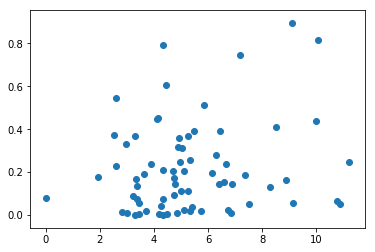

In [192]:
df_anesthesie = df_specialistes[df_specialistes["Spécialistes"]
                                == "TOTAL ANESTHESIE REANIMATION  (02, 20)"]
df_anesthesie = pd.merge(df_anesthesie, df_honoraires, how='inner')
df_anesthesie = df_anesthesie.drop(columns=["EFFECTIFS"])
df_anesthesie = df_anesthesie.drop([96, 102, 103])
df_anesthesie.tail(20)
df_anesthesie["taux_depassement"] = df_anesthesie["DEPASSEMENTS (Euros)"] / \
    df_anesthesie["HONORAIRES SANS DEPASSEMENT (Euros)"]
df_anesthesie["dept_code"] = df_anesthesie["DEPARTEMENT"].str.split('- ').str[0]

plt.figure()
plt.scatter(df_anesthesie["DENSITE /100 000 hab."],df_anesthesie["taux_depassement"])
plt.show()

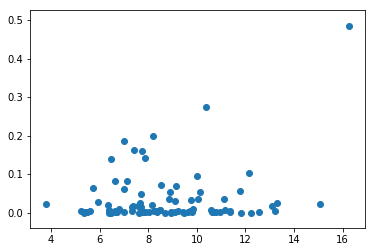

In [203]:
def display_spe(spe):
    df_spe = df_specialistes[df_specialistes["Spécialistes"] == spe]
    df_spe = pd.merge(df_spe, df_honoraires, how='inner')
    df_spe = df_spe.drop(columns=["EFFECTIFS"])
    #print(df_spe.describe())
    df_spe = df_spe.drop([96, 102, 103])
    df_spe["taux_depassement"] = df_spe["DEPASSEMENTS (Euros)"] / \
        df_spe["HONORAIRES SANS DEPASSEMENT (Euros)"]
    df_spe["dept_code"] = df_spe["DEPARTEMENT"].str.split('- ').str[0]

    plt.figure()
    plt.scatter(df_spe["DENSITE /100 000 hab."],df_spe["taux_depassement"])
    plt.show()
    
display_spe("TOTAL RADIOLOGIE  (72, 74, 76, 06)")

In [204]:
display_spe("TOTAL CHIRURGIE  (43, 44, 46, 47, 48, 49, 04, 10, 16 ,41)")

KeyError: '[96 102 103] not found in axis'

In [199]:
df_spe.tail(100)

,Spécialistes,DEPARTEMENT,EFFECTIF,POPULATION FRANCAISE,DENSITE /100 000 hab.,HONORAIRES SANS DEPASSEMENT (Euros),DEPASSEMENTS (Euros),FRAIS DE DEPLACEMENT (Euros),TOTAL DES HONORAIRES (Euros),taux_depassement,dept_code
1,"TOTAL RADIOLOGIE (72, 74, 76, 06)",02- Aisne,34,5.343000e+05,6.363467,1.951021e+07,131508.38,0.00,1.964172e+07,0.006740,02
2,"TOTAL RADIOLOGIE (72, 74, 76, 06)",03- Allier,33,3.390000e+05,9.734514,1.779230e+07,94007.76,0.00,1.788630e+07,0.005284,03
3,"TOTAL RADIOLOGIE (72, 74, 76, 06)",04- Alpes-Hte-Provence,9,1.617000e+05,5.565863,NaN,NaN,NaN,NaN,NaN,04
4,"TOTAL RADIOLOGIE (72, 74, 76, 06)",05- Hautes-Alpes,10,1.416000e+05,7.062147,NaN,NaN,NaN,NaN,NaN,05
5,"TOTAL RADIOLOGIE (72, 74, 76, 06)",06- Alpes-Maritimes,163,1.080600e+06,15.084213,9.377779e+07,2106542.28,0.00,9.588433e+07,0.022463,06
6,"TOTAL RADIOLOGIE (72, 74, 76, 06)",07- Ardèche,18,3.286000e+05,5.477785,6.663338e+06,7743.07,0.00,6.671081e+06,0.001162,07
7,"TOTAL RADIOLOGIE (72, 74, 76, 06)",08- Ardennes,19,2.713000e+05,7.003318,1.007007e+07,8169.57,0.00,1.007824e+07,0.000811,08
8,"TOTAL RADIOLOGIE (72, 74, 76, 06)",09- Ariège,7,1.523000e+05,4.596192,NaN,NaN,NaN,NaN,NaN,09
9,"TOTAL RADIOLOGIE (72, 74, 76, 06)",10- Aube,24,3.116000e+05,7.702183,1.164042e+07,17104.92,0.00,1.165752e+07,0.001469,10
10,"TOTAL RADIOLOGIE (72, 74, 76, 06)",11- Aude,42,3.702000e+05,11.345219,1.773820e+07,6597.00,0.00,1.774480e+07,0.000372,11


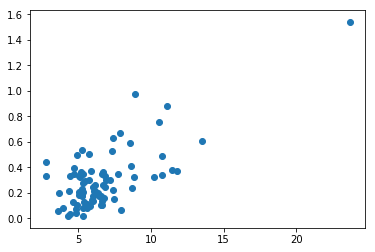

In [205]:
display_spe("TOTAL GYNECOLOGIE  (70, 77, 79, 07)")


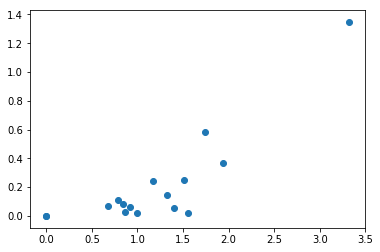

In [206]:
display_spe("TOTAL MEDECINE INTERNE  (71, 73, 09)")

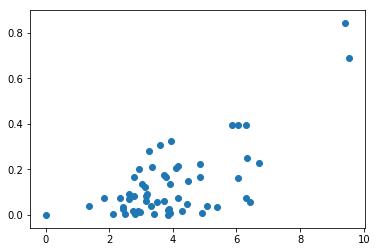

In [207]:
display_spe("TOTAL PEDIATRIE  (78, 12)")


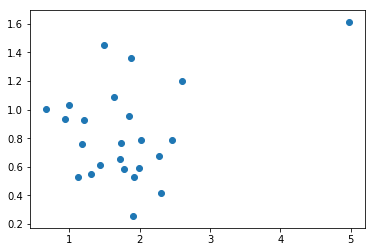

In [208]:
display_spe("TOTAL STOMATOLOGIE  (69, 45, 18)")

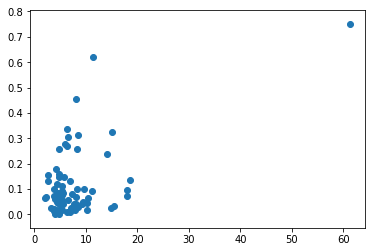

In [209]:
display_spe('TOTAL PSYCHIATRIE  (75, 33, 17)')

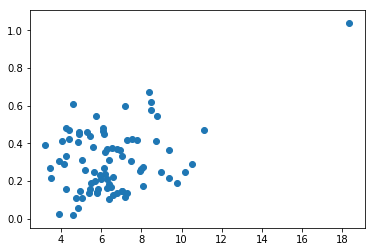

In [210]:
display_spe('15- Ophtalmologie')

## Réponses

Peut-on établir un lien entre la densité de médecins par spécialité et par territoire et la pratique du dépassement d'honoraires ?
Est-ce dans les territoires où la densité est la plus forte que les médecins pratiquent le moins les dépassements d'honoraires ?

On remarque que la pratique du dépassement d'honoraires est plus forte dans les départements à forte densité de médecins spécialistes. Ce qui peut sembler étonnant a priori : la forte densité de spécialistes ne crée pas de concurrence sur les honoraires. Cela peut peut-être s'expliquer par la possibilité qu'ont les médecins de choisir où s'établir : un spécialiste interessé pour facturer plus cher peut s'installer là où la demande et les revenus des patients sont élevés.
Dans le cas de Paris, où la densité de spécialistes est très forte et les dépassements d'honoraires bien plus élevés qu'ailleurs, le prix des loyers et l'attractivité (les patients viennent parfois de loin) peut expliquer cette situation particulière.

Nous n'avons pas réussi à trouver d'après la carte de France quels paramètres pourraient expliquer des situations très contrastées entre des territoires à fort dépassement comme la région parisienne, la région lyonnaise et une partie de la Normandie, vs. l'ouest et le sud ouest.

Dans le diagramme des spécialistes, il semble y avoir plusieurs patterns, on remarque que les situations sont très différentes selon les spécialités, sans que nous ayons réussi à en déduire des conclusions pertinentes.
Pour certaines spécialités, on remarque que dans beaucoup de territoires il n'y a quasi aucun dépassement d'honoraires.

### 3. Densité de médecins et densité de population pour certaines classes d'âge

Est-ce que la densité de certains médecins / praticiens est corrélée à la densité de population pour certaines classes d'âges (bébé/pédiatre, personnes âgées / infirmiers etc...) ?